In [344]:
import librosa
from librosa.feature import melspectrogram
import matplotlib.pyplot as plt
import numpy as np
from pydub import AudioSegment
import pandas as pd
import scipy
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC

# <font color='GoldenRod'>Select and Generate Features for our Model</font>

# Spectral Centroid
Indicates where the center of mass of the spectrum is located.

In [345]:
def spectral_centroids(x, sr):
    spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]
    frame_names = ["spectral_centroid_{}".format(i) for i in range(spectral_centroids.shape[0])]
    return dict(zip(frame_names, spectral_centroids))

# Spectral Bandwidth
Describes the width of the spectrum

In [346]:
def spectral_bandwidth(x, sr):
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=x, sr=sr)[0]
    frame_names = ["spectral_bandwidth_{}".format(i) for i in range(spectral_bandwidth.shape[0])]
    return dict(zip(frame_names, spectral_bandwidth))

# Energy

The RMS Energy (RMSE) is the square root of the mean squared amplitude over the length of the recording

In [347]:
def rmse(x):
    return {'rmse': np.sum(x**2)}

# Zero-Crossing Rate
The Zero Crossing Rate (ZCR) measures the rate at which the signal changes sign (crosses the zero value on the amplitude axis).

In [348]:
def zero_crossings(x):
    return {'zero_crossing': sum(librosa.zero_crossings(x, pad=False))}

# Beats Per Minute (BPM)

In [349]:
def bpm(x, sr):
    # Estimate the tempo from the onset strength envelope
    tempo, _ = librosa.beat.beat_track(y=x, sr=sr)
    return {'bpm': tempo}

# Pitch
Pitch is an important characteristic in speaker identification. Features like the average pitch, pitch variance, and max/min pitch

In [350]:
def pitch_stats(x, sr):
    #estimate pitch information
    pitches, magnitudes = librosa.piptrack(y=x, sr=sr)

    # Finding the index of the maximum magnitude for each time frame
    indices = magnitudes.argmax(axis=0)
    # Extracting the pitches with the highest magnitude
    pitch_track = np.take_along_axis(pitches, indices[None, :], axis=0).flatten()
    # Removing zero-valued entries (which represent frames with no significant pitch)
    pitch_track = pitch_track[pitch_track > 0]

    average_pitch = np.mean(pitch_track)
    pitch_variance = np.var(pitch_track)
    max_pitch = np.max(pitch_track)
    min_pitch = np.min(pitch_track)
    return {'average_pitch': average_pitch, 'pitch_variance': pitch_variance,
            'max_pitch': max_pitch, 'min_pitch': min_pitch}

# Spectral Contrast
This feature measures the spectral peakiness or flatness, which can vary between speakers. It can be useful in various audio analysis tasks, such as music genre classification, speech/music discrimination, and instrument recognition.

In [351]:
def spectral_contrast(x, sr):
    # Compute the STFT and spectral contrast
    S = np.abs(librosa.stft(x))
    spectral_contrast = librosa.feature.spectral_contrast(S=S, sr=sr)

    # Aggregate spectral contrast features over time
    # For example, taking the mean across all time frames for each band
    mean_spectral_contrast = np.mean(spectral_contrast, axis=1)

    # Generate feature names for each frequency band
    n_bands = mean_spectral_contrast.shape[0]
    feature_names = [f'Mean_SpectralContrast_Band{band+1}' for band in range(n_bands)]
    return dict(zip(feature_names, mean_spectral_contrast))

# Mel Frequency Cepstral Coefficients (MFCC)
They capture information about the shape of the spectral envelope, resonant frequencies, and other spectral characteristics that are unique to each speaker. MFCCs are somewhat invariant to certain types of speaker variability, such as variations in pitch and speaking rate. This makes them robust features for speaker recognition across different speaking conditions.

In [352]:
def mfccs_stats(x, sr):
    mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=13)
    # Calculate statistics across the time dimension (axis=1)
    mfccs_mean = np.mean(mfccs, axis=1)  # Mean of each MFCC coefficient
    mfccs_std = np.std(mfccs, axis=1)    # Standard deviation of each MFCC coefficient

    # Concatenate the statistics to create a feature vector
    feature_vector = np.concatenate((mfccs_mean, mfccs_std), axis=0)
    feature_names_arr = []
    for i in range(0,14,1):
        feature_names_arr.append('mfcc_mean_' + str(i))
    for j in range (0,14,1):  
        feature_names_arr.append('mfcc_std_' + str(j))
    return dict(zip(feature_names_arr, feature_vector))

# Mel Frequency Differential Coefficients
The first-order coefficients capture the rate of change, and the second-order coefficients capture the acceleration of changes in the cepstral features.

In [353]:
def mfdcs(x, sr):
    mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)

    mfccs_delta_mean = np.mean(mfcc_delta, axis=1)
    mfccs_delta_std = np.std(mfcc_delta, axis=1)
    mfccs_delta2_mean = np.mean(mfcc_delta2, axis=1)
    mfccs_delta2_std = np.std(mfcc_delta2, axis=1)
    
    overall_delta_mean = np.mean(mfccs_delta_mean)
    overall_delta_std = np.mean(mfccs_delta_std)
    overall_delta2_mean = np.mean(mfccs_delta2_mean)
    overall_delta2_std = np.mean(mfccs_delta2_std)

    return {'overall_delta_mean' : overall_delta_mean, 'overall_delta_std': overall_delta_std,
            'overall_delta2_mean': overall_delta2_mean, 'overall_delta2_std': overall_delta2_std}

# <font color='GoldenRod'>Assemble and Build our Dataset</font>
This will extract our selected features from our recording segments and produce a pandas dataframe.

In [354]:
import os
import re

directory = 'data/half_sec'

df = pd.DataFrame()
rows = []

# Load audio data
for filename in os.listdir(directory):
    values = {}
    if filename.endswith(".mp3"):  # or any other file extension
        file_path = os.path.join(directory, filename)
        # Now you can read or process the file
        #print(f"Processing {file_path}")
        
        # load file and extract raw audio data
        x, sr = librosa.load(f"{file_path}", sr=16000)
        
        # add spectral centroid
        values.update(spectral_centroids(x, sr)) 
        
        # add spectral bandwidth
        values.update(spectral_bandwidth(x, sr)) 
        
        # add rmse
        values.update(rmse(x))
        
        # add zero crossings
        values.update(zero_crossings(x))
        
        # add BPM
        values.update(bpm(x, sr))
        
        # add pitch stats
        values.update(pitch_stats(x, sr))
        
        # add spectral contrast
        values.update(spectral_contrast(x, sr))
        
        # add Mel Frequency Cepstral Coefficients
        values.update(mfccs_stats(x, sr))
        
        # add Mel Frequency Differential Coefficients
        values.update(mfdcs(x, sr))
        
        # add classification (i.e. speaker name) by extracting from filename
        pattern = fr"{directory}/([^_]+)"
        match = re.search(pattern, file_path)
        name = match.group(1)  # The captured group
        values.update({'speaker': name})

        rows.append(values)
        
    else:
        continue  # not an mp3 file
        
df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)


In [355]:
df.shape

(742, 77)

In [356]:
df.tail(3)

,spectral_centroid_0,spectral_centroid_1,spectral_centroid_2,spectral_centroid_3,spectral_centroid_4,spectral_centroid_5,spectral_centroid_6,spectral_centroid_7,spectral_centroid_8,spectral_centroid_9,...,mfcc_std_7,mfcc_std_8,mfcc_std_9,mfcc_std_10,mfcc_std_11,overall_delta_mean,overall_delta_std,overall_delta2_mean,overall_delta2_std,speaker
739,1325.463053,1425.981558,1386.120849,1195.783674,1155.795837,1040.430799,1171.232035,1399.797304,1533.234492,1596.137017,...,14.715127,6.644163,7.865900,5.010445,6.782481,-0.035663,3.251832,0.085132,1.755211,Monika
740,1158.575783,1087.661361,1030.203902,1111.395253,1113.839455,1094.193324,1089.458867,1023.449943,1011.134305,960.234900,...,5.764329,4.580482,4.073467,5.568580,3.636134,-0.433573,1.302406,0.011739,0.991060,Max
741,813.582133,845.769897,869.525338,905.190753,1209.728446,1565.897098,1354.819531,1037.673992,960.171185,1041.220988,...,9.297060,10.926280,4.587485,4.845984,7.610810,0.184012,1.774240,0.017245,1.276657,Max


In [357]:
df['speaker'].value_counts()

James     244
Max       190
Monika    177
Henry     131
Name: speaker, dtype: int64

## Train Test Split
Employ stratification to ensure classes are proportionally represented in the train and test data. This helps given our data data is imbalanced. 

In [358]:
X = df.drop('speaker', axis=1)
y = df['speaker']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22, test_size=.2, stratify=y)

# <font color='GoldenRod'>SVM Model</font>

In [359]:
params = {'svc__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
          'poly__degree' : [2],
          'svc__gamma': [0.1, 1.0, 10.0, 100.0],}

pipe = Pipeline([('scaler', StandardScaler()),
                 ('poly', PolynomialFeatures()),
                 ('svc', SVC())])

grid = GridSearchCV(pipe, param_grid=params, cv=10, n_jobs=-1, scoring='accuracy').fit(X_train, y_train)
grid_score = grid.score(X_test, y_test)
best_kernel = grid.best_params_['svc__kernel']
best_gamma = grid.best_params_['svc__gamma']

print("grid_score : {}".format(grid_score))
print("best_kernel : {}".format(best_kernel))
print("best gamma : {}".format(best_gamma))

grid_score : 0.8523489932885906
best_kernel : linear
best gamma : 0.1


# <font color='GoldenRod'>SVM Performance</font>
## Confusion Matrix - SVM
The confusion matrix below indicates there may be a slight biases for Class 1 and 3. With further data pre-preprocessing, it would be useful to observe how our grid changes. We may also consider selecting additional features that assist with better classification. 


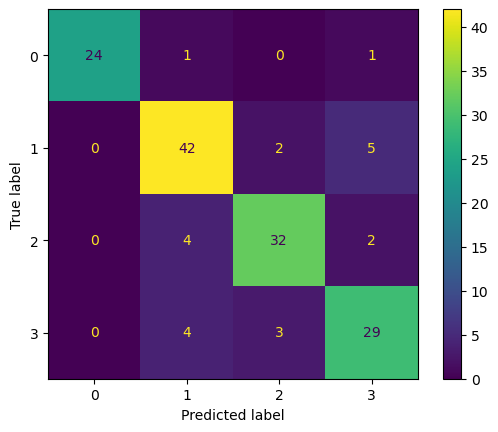

In [360]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plotting
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# <font color='GoldenRod'>Logistic Regression Model</font>

In [361]:
# Select Features for our Model using Logistic Regression with l1 penalty
extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42))

# Create our pipeline with a StandardScaler and our Extractor
lgr_pipe = Pipeline([('scaler', StandardScaler()),
                     ('selector', extractor),
                     ('lgr', LogisticRegression(random_state=22, max_iter=20000))])


# Perform a grid search over our hyperparamaters
# One-vs-Rest (OVR) was selected because our classes are mutually exclusive
# liblinear selected because it's genrally efficient with small data sets, and supports l1 and l2 regularization
param_grid = {
    'lgr__solver': ['liblinear'],
    'lgr__penalty': ['l1', 'l2'],
    'lgr__multi_class': ['ovr'],
    'lgr__class_weight': ['balanced', None],
    'lgr__fit_intercept': [True, False]
}

# We want high accuracy to enable security and forensic applications
grid = GridSearchCV(lgr_pipe, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
acc = grid.score(X_test, y_test)

best_penalty = grid.best_params_['lgr__penalty']
best_multi_class = grid.best_params_['lgr__multi_class']
best_class_weight = grid.best_params_['lgr__class_weight']
best_fit_intercept = grid.best_params_['lgr__fit_intercept']

print("accuracy score : {}".format(acc))
print("best penalty: {}".format(best_penalty))
print("best multi_class: {}".format(best_multi_class))
print("best class weight : {}".format(best_class_weight))
print("fit intercept : {}".format(best_fit_intercept))

accuracy score : 0.8389261744966443
best multi_class: l1
best multi_class: ovr
best class weight : None
best fit intercept : True


# <font color='GoldenRod'>Logistic Regression Performance</font>
## Confusion Matrix - Logistic Regression
The confusion matrix below indicates there may be a slight biases for Class 1 and 3. With further data pre-preprocessing, it would be useful to observe how our grid changes. We may also consider selecting additional features that assist with better classification. 

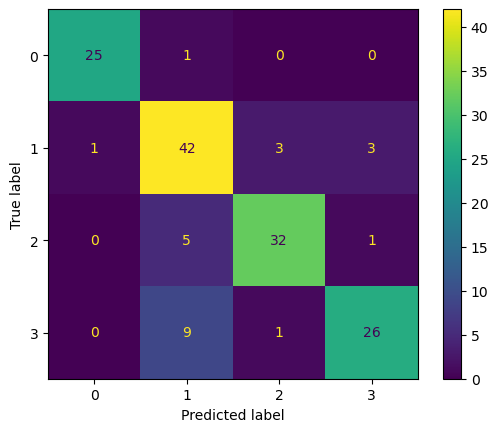

In [362]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plotting
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
